# A CNN to diagnose breast cancer

We will code a convolutional neural network (CNN) that is able to differentiate between two rare types of breast cancer, lobular carcinoma and papillary carcinoma, based on histology images from the BreaKHis_v1 dataset (https://web.inf.ufpr.br/vri/databases/breast-cancer-histopathological-database-breakhis/). We will use the deep learning framework Keras on top of TensorFlow.

CNNs are a type of neural networks which are especially suited to deal with images because they apply subsequent rounds of convolution and pooling operations that act as Gabor filters to extract progressively more complex features. Pooling operations are loosely inspired on how the human brain processes signals from the eye.

The following image shows a diagram of convolution and pooling operations (courtesy of Adit Deshpande).

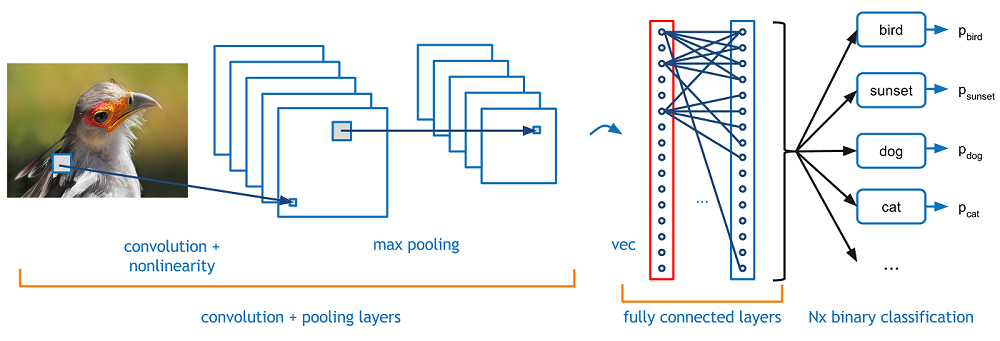

In [1]:
from IPython.display import Image
Image("Cover.png")

Our dataset contains microscopy images from two types of tumpor samples, lobular carcinoma and papillary carcinoma. Let's take a look at what they look like. We can visualize them with the module PIL.

Lobular carcinoma


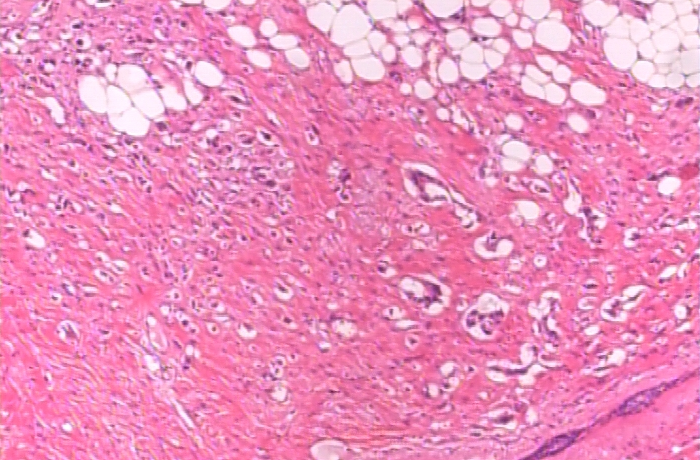

In [2]:
from PIL import Image
print('Lobular carcinoma')
Image.open('lobular_carcinoma/SOB_M_LC-14-15570C-40-025.png')

Papillary carcinoma


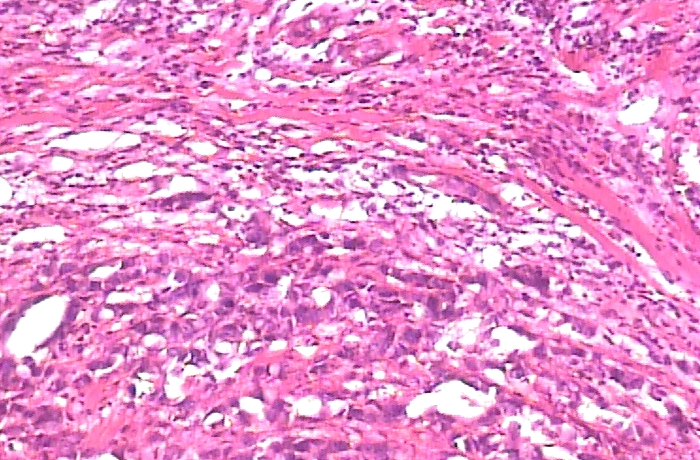

In [3]:
print('Papillary carcinoma')
Image.open('papillary_carcinoma/SOB_M_PC-15-190EF-100-009.png')

To me, a biotechnologist / data scientist with no experience in histology, these two samples look pretty similar. Hopefully, a trained CNN will be able to do much better!

## 1. Preprocess the data

### a) Load the images

The first we have to do is converting the images to a format that will be understood by the CNN. Neural networks speak the language of tensors, so we will convert our dataset to one. For this, we'll use Numpy and we'll represent real numbers with single precision (i.e. 32 bits) to keep memory usage low.

In [4]:
import glob
import numpy as np

In [5]:
lobular_images = glob.glob('lobular_carcinoma/*.png')
lobular = np.zeros((len(lobular_images),460,700,3)).astype(np.float32)
for i,image in enumerate(lobular_images[:len(lobular_images)]):
    lobular[i] = np.array(Image.open(image)).astype(np.float32)

In [6]:
papillary_images = glob.glob('papillary_carcinoma/*.png')
papillary = np.zeros((len(papillary_images),460,700,3)).astype(np.float32)
for i,image in enumerate(papillary_images[:len(papillary_images)]):
    if np.array(Image.open(image)).shape[0] == 460:
        papillary[i] = np.array(Image.open(image)).astype(np.float32)

Our dataset contains 626 pictures of lobular carcinoma and 560 of capillary carcinoma, each of them of size 460x700 pixels and with 3 colors or channels.

In [7]:
lobular.shape

(626, 460, 700, 3)

In [8]:
papillary.shape

(560, 460, 700, 3)

Finally, we will label all lobular samples as 0 and all papillary as 1.

In [9]:
Y_lobular = np.zeros(lobular.shape[0])
Y_papillary = np.ones(papillary.shape[0])

### b) Scale

In order to make the most of our data, it is recommended to scale it so that all features (i.e. each pixel in each channel) has roughly the same mean and standard deviation accross all samples. This way, it will be easier for the CNN to identify which features are most informative. 

We will achieve a mean of 0 and standard deviation of 1 in all features by substracting the mean and dividing by the standard deviation.

In [10]:
X = np.concatenate((lobular,papillary),axis=0)
Y = np.concatenate((Y_lobular,Y_papillary),axis=0)
del lobular, papillary, Y_lobular, Y_papillary

X_scl = np.divide(X - X.mean(axis = 0), X.std(axis = 0))
del X

### c) Split into training, validation and test sets

We will follow the standard choice of 60% of training and 20% for validation and test. Note that, in order to avoid unwanted biases, we have to randomly permute the samples before splitting. That way we ensure that the training, validation and test sets are homogeneous.

In [11]:
random_order = np.random.permutation(X_scl.shape[0])
X_scl = X_scl[random_order]
Y = Y[random_order]

twenty_percent = int(X_scl.shape[0]*0.2)
X_train = X_scl[:twenty_percent*3]
Y_train = Y[:twenty_percent*3]
X_val = X_scl[twenty_percent*3:twenty_percent*4]
Y_val = Y[twenty_percent*3:twenty_percent*4]
X_test = X_scl[twenty_percent*4:]
Y_test = Y[twenty_percent*4:]

In [12]:
del X_scl,Y

## 2. Train the model

For the architecture, our CNN will consist of: 3 convolutional layers (convolution + pooling), 2 convolutional layers and the output layer. 

All activations will be Rectified Linear Units (ReLU), which have been shown to lead to fast optimization by backpropagation. For the output layer, however, we will use the logistic or sigmoid function. This function ranges between 0 and 1, so it can be interpreted as probabilities during binary classification. 

Finally, we will attempt to prevent overfitting by applying dropout regularization, where a fraction of the units are dropped randomly. This type of regularization has become widespread in deep learning because it is very convenient and also leads to robust models. An intuitive way of understanding such robustness is that the network learns that it cannot completely rely on any individual neuron, but must make predictions which are supported on many neurons collectively.

In [13]:
from keras.models import Model
from keras.layers import Dense, Dropout, Input,Conv2D, MaxPooling2D, Flatten
from keras.optimizers import Adam

/home/frozenmiwe/anaconda3/envs/music/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [14]:
def model(input_shape,rate):
    
    a,b,c = input_shape
    X_input = Input(shape = (a,b,c,))
    
    # Convolutions
    
    X = Conv2D(32, kernel_size = (16,16), strides=(2,2), activation='relu')(X_input)
    X = MaxPooling2D(pool_size = (2,2), strides=(2,2))(X)
    X = Conv2D(64, kernel_size = (16,16), strides=(2,2), activation='relu')(X)
    X = MaxPooling2D(pool_size = (2,2), strides=(2,2))(X)
    X = Conv2D(16, kernel_size = (16,16), strides=(2,2), activation='relu')(X)
    X = MaxPooling2D(pool_size = (2,2), strides=(2,2))(X)
    
    # Fully connected
    
    X = Flatten()(X)
    X = Dense(1000, activation='relu')(X)
    X = Dropout(rate)(X)
    X = Dense(100, activation='relu')(X)
    X = Dropout(rate)(X)
    
    # Output layer
    
    X = Dense(1, activation='sigmoid')(X)
    
    model = Model(inputs = X_input, outputs = X)    
    return(model)

A model with this architecture ends up having ~$10^6$ trainable parameters.

In [15]:
input_shape = X_train[0].shape
my_model = model(input_shape,rate=0.05)
my_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 460, 700, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 223, 343, 32)      24608     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 111, 171, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 48, 78, 64)        524352    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 24, 39, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 5, 12, 16)         262160    
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 2, 6, 16)          0         
__________

Note that the choice of an architecture is actually a hyperparameter that must be tuned.

### a) Tune the hyperparameters

A machine learning model always has some parameters which cannot be optimized by the optimization algorithm. Instead, they have to be chosen manually. Examples include the learning rate, the architecture, the optimizer itself (whether it is gradient descent, Adam, Adadelta, etc.) or the training time in epochs (an epoch is a single pass through the training set).

The optimal values of these hyperparameters are found by sampling: for each combination of hyperparameters to sample, first we train on the training set, and then we evaluate the accuracy obtained on the validation set (in fact, tuning the hyperparameters is the main purpose of having a validation set). In this case, I've already found that the network above and 30 epochs are a good architecture and training time respectively (not shown). We still have to find the appropriate dropout rate.

#### A large dropout rate leads to underfitting

Dropout is a regularization technique that works in the following way: for each forward propagation, randomly select a fraction of neurons in each layer and render them inactive, as though they didn't exist. This way, the network learns to make predictions that are spread out throughout all neurons, rather than very reliant on a small number of highly important neurons. The fraction of neurons to drop is called the dropout rate.

Our first guess at the dropout rate will be 0.8. We will use the optimization algorithm Adam (ADAptive Moment estimation), a sophisticated type of gradient descent that has momentum. This means that, in order to estimate how much the parameters will vary in each optimization iteration, both the current gradient and previous gradients are considered. If we make an analogy with physics, a ball descending downhill has a velocity that depends not only on the current slope, but also on the momentum it has accumulated as a result of previous slopes. Hence the "descent with momentum" name.

In [16]:
my_model = model(input_shape,rate=0.8)
opt = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, decay=0.01)
my_model.compile(loss='binary_crossentropy', optimizer=opt, metrics=["accuracy"])
my_model.fit(X_train, Y_train.reshape(-1,1), batch_size = 50, epochs=30)

Epoch 1/30
711/711 [==============================] - 14s 19ms/step - loss: 0.7197 - acc: 0.5105
Epoch 2/30
711/711 [==============================] - 10s 13ms/step - loss: 0.6920 - acc: 0.5302
Epoch 3/30
711/711 [==============================] - 10s 14ms/step - loss: 0.6842 - acc: 0.4895
Epoch 4/30
711/711 [==============================] - 10s 14ms/step - loss: 0.6621 - acc: 0.5120
Epoch 5/30
711/711 [==============================] - 10s 14ms/step - loss: 0.6166 - acc: 0.5274
Epoch 6/30
711/711 [==============================] - 10s 14ms/step - loss: 0.6262 - acc: 0.6371
Epoch 7/30
711/711 [==============================] - 10s 14ms/step - loss: 0.6018 - acc: 0.6864
Epoch 8/30
711/711 [==============================] - 10s 14ms/step - loss: 0.6026 - acc: 0.7004
Epoch 9/30
711/711 [==============================] - 10s 14ms/step - loss: 0.5897 - acc: 0.7187
Epoch 10/30
711/711 [==============================] - 10s 14ms/step - loss: 0.5795 - acc: 0.7215
Epoch 11/30
711/711 [========

In [17]:
my_model.evaluate(X_train, Y_train)

711/711 [==============================] - 5s 7ms/step


[0.5115680921345991, 0.8045007032348804]

In [18]:
my_model.evaluate(X_val, Y_val)

237/237 [==============================] - 2s 7ms/step


[0.495084643615449, 0.7594936713890688]

As we can see, a relatively low accuracy is achieved during both training and validation. This means that the classifier is **underfitting**, i.e. it doesn't have enough flexibility do fit the data correctly. In machine learning talk, this flexibility is called capacity. In order to increase the classifier's capacity, we need to decrease the regularization by decreasing the dropout rate.

#### A small dropout rate leads to overfitting

Our next guess at the dropout rate will be 0.001.

In [19]:
my_model = model(input_shape,rate=0.001)
opt = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, decay=0.01)
my_model.compile(loss='binary_crossentropy', optimizer=opt, metrics=["accuracy"])
my_model.fit(X_train, Y_train.reshape(-1,1), batch_size = 50, epochs=30)

Epoch 1/30
711/711 [==============================] - 10s 14ms/step - loss: 0.5519 - acc: 0.7384
Epoch 2/30
711/711 [==============================] - 10s 14ms/step - loss: 0.4097 - acc: 0.8284
Epoch 3/30
711/711 [==============================] - 10s 14ms/step - loss: 0.3692 - acc: 0.8439
Epoch 4/30
711/711 [==============================] - 10s 14ms/step - loss: 0.3821 - acc: 0.8340
Epoch 5/30
711/711 [==============================] - 15s 21ms/step - loss: 0.3432 - acc: 0.8579
Epoch 6/30
711/711 [==============================] - 15s 21ms/step - loss: 0.3148 - acc: 0.8748
Epoch 7/30
711/711 [==============================] - 16s 22ms/step - loss: 0.3017 - acc: 0.8565
Epoch 8/30
711/711 [==============================] - 20s 28ms/step - loss: 0.2964 - acc: 0.8748
Epoch 9/30
711/711 [==============================] - 19s 26ms/step - loss: 0.2738 - acc: 0.8805
Epoch 10/30
711/711 [==============================] - 17s 23ms/step - loss: 0.2614 - acc: 0.8931
Epoch 11/30
711/711 [========

In [20]:
my_model.evaluate(X_train, Y_train)

711/711 [==============================] - 7s 10ms/step


[0.07984148544611726, 0.9845288326300985]

In [21]:
my_model.evaluate(X_val, Y_val)

237/237 [==============================] - 2s 10ms/step


[0.2522848458481237, 0.9113924050632911]

As we can see, there is a large difference between the train accuracy and the validation accuracy. That means that the classifier is **overfitting**, i.e. given the permissive regularization it is very flexible and can memorize the training labels instead of learning the overall trends in the dataset. This is undesirable because if it doesn't learn the overall trends, it will do poorly on unseen data, i.e. it will not generalize.

Let's try again with a larger dropout rate.

### A medium dropout rate leads to high validation accuracy

Let's try now with a rate between 0.8 and 0.001. For example, 0.0015.

In [22]:
my_model = model(input_shape,rate=0.0015)
opt = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, decay=0.01)
my_model.compile(loss='binary_crossentropy', optimizer=opt, metrics=["accuracy"])
my_model.fit(X_train, Y_train.reshape(-1,1), batch_size = 50, epochs=30)

Epoch 1/30
711/711 [==============================] - 10s 14ms/step - loss: 0.5648 - acc: 0.6779
Epoch 2/30
711/711 [==============================] - 10s 14ms/step - loss: 0.4467 - acc: 0.7947
Epoch 3/30
711/711 [==============================] - 10s 14ms/step - loss: 0.4044 - acc: 0.8172
Epoch 4/30
711/711 [==============================] - 10s 14ms/step - loss: 0.3963 - acc: 0.8101
Epoch 5/30
711/711 [==============================] - 10s 14ms/step - loss: 0.3628 - acc: 0.8523
Epoch 6/30
711/711 [==============================] - 10s 15ms/step - loss: 0.3405 - acc: 0.8565
Epoch 7/30
711/711 [==============================] - 16s 23ms/step - loss: 0.3364 - acc: 0.8636
Epoch 8/30
711/711 [==============================] - 17s 24ms/step - loss: 0.3025 - acc: 0.8692
Epoch 9/30
711/711 [==============================] - 19s 27ms/step - loss: 0.2833 - acc: 0.8776
Epoch 10/30
711/711 [==============================] - 21s 29ms/step - loss: 0.2666 - acc: 0.8945
Epoch 11/30
711/711 [========

In [23]:
my_model.evaluate(X_train, Y_train)

711/711 [==============================] - 7s 10ms/step


[0.09955647038151778, 0.9662447257383966]

In [24]:
my_model.evaluate(X_val, Y_val)

237/237 [==============================] - 2s 10ms/step


[0.18789892440921144, 0.9493670886075949]

At a dropout rate of 0.0015, the classifier doesn't overfit (the difference between the training and validation accuracies is small) and doesn't underfit (the training accuracy is high). We obtain a validation accuracy of 94.94%, which is pretty good.

### b) Retrain on training and validation set

Now that we know an optimal choice of hyperparameters, we want to train on as many samples as possible before evaluating on the test set. Therefore, we'll combine the training and validation sets to train the final model.

In [34]:
my_model = model(input_shape,rate=0.0015)
opt = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, decay=0.01)
my_model.compile(loss='binary_crossentropy', optimizer=opt, metrics=["accuracy"])
my_model.fit(np.append(X_train,X_val, axis=0), np.append(Y_train,Y_val,axis=0), batch_size = 50, epochs=30)

Epoch 1/30
948/948 [==============================] - 14s 15ms/step - loss: 0.4846 - acc: 0.7722
Epoch 2/30
948/948 [==============================] - 13s 14ms/step - loss: 0.3742 - acc: 0.8439
Epoch 3/30
948/948 [==============================] - 13s 14ms/step - loss: 0.3337 - acc: 0.8608
Epoch 4/30
948/948 [==============================] - 13s 14ms/step - loss: 0.3278 - acc: 0.8660
Epoch 5/30
948/948 [==============================] - 13s 14ms/step - loss: 0.2932 - acc: 0.8734
Epoch 6/30
948/948 [==============================] - 14s 14ms/step - loss: 0.2763 - acc: 0.8797
Epoch 7/30
948/948 [==============================] - 14s 15ms/step - loss: 0.2317 - acc: 0.8966
Epoch 8/30
948/948 [==============================] - 14s 14ms/step - loss: 0.1968 - acc: 0.9167
Epoch 9/30
948/948 [==============================] - 15s 16ms/step - loss: 0.1828 - acc: 0.9272
Epoch 10/30
948/948 [==============================] - 19s 20ms/step - loss: 0.1630 - acc: 0.9367
Epoch 11/30
948/948 [========

In [35]:
my_model.evaluate(X_test,Y_test)

238/238 [==============================] - 3s 11ms/step


[0.18853332966315647, 0.924369748400039]

We have obtained a model that is able to classify lobular carcinoma and papillary carcinoma with an accuracy of 92.44%. The 2% difference between the validation accuracy and the test accuracy is probably due to the fact that we have overfit slightly to the validation set.